In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-multilearn
!pip install swifter
#!pip install fast-ml

     |████████████████████████████████| 89 kB 3.7 MB/s 
     |████████████████████████████████| 296 kB 6.4 MB/s 
     |████████████████████████████████| 118 kB 56.6 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [3]:
import json
import string
import re
import nltk
import numpy as np
import pandas as pd
import swifter
from collections import Counter
from scipy import sparse
from tqdm import tqdm
from scipy.stats import norm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from skmultilearn.adapt import MLkNN
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.feature_selection import SelectFromModel
from multiprocessing import  Pool
#from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from skmultilearn.ensemble import RakelD
from lightgbm import LGBMClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import f1_score, roc_auc_score

In [4]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.


KeyboardInterrupt: ignored

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/arxiv_random_all_catogs/arxiv_random_stratified.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
def preprocess(text):
    clean_text = text.strip()
    clean_text = clean_text.lower()
    clean_text = re.sub(r'\d+','',clean_text)
    lookup_table = clean_text.maketrans('', '', string.punctuation)
    clean_text = clean_text.translate(lookup_table)
    word_list = word_tokenize(clean_text)
    word_list = [w for w in word_list if not w in stop_words]
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    clean_text = ' '.join(word_list)
    return clean_text


In [ ]:
df['clean_abstract'] = df['abstract'].swifter.apply(preprocess)

In [ ]:
df = df[['clean_abstract','categories']]

In [ ]:
df

,clean_abstract,categories
0,describe new algorithm kellpebble game color u...,"['math', 'cs']"
1,paper present algorithm computing hecke eigens...,['math']
2,pure spinor formulation tendimensional superst...,['hep-th']
3,note give new method getting series approximat...,['math']
4,xqm quark emit goldstone boson flavor symmetry...,['hep-ph']
...,...,...
354267,using rational rmatrix associated x defining m...,"['math', 'solv-int', 'nlin', 'math-ph']"
354268,family completely integrable nonlinear deforma...,"['math', 'solv-int', 'nlin']"
354269,three inequivalent real form complex n supersy...,"['hep-th', 'nlin', 'math', 'solv-int', 'math-ph']"
354270,three nonequivalent real form complex twisted ...,"['hep-th', 'nlin', 'math', 'solv-int', 'math-ph']"


In [ ]:
df['categories'] = df['categories'].apply(lambda x:x.split())

In [ ]:
import ast

def convert_categories(row):
    return ast.literal_eval(row)
    new_list = []
    for cat in row:
        new_cat = ast.literal_eval(cat)
        new_list.append(new_cat)
    return new_list


In [ ]:
df['categories'] = df['categories'].map(convert_categories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

,clean_abstract,categories
0,describe new algorithm kellpebble game color u...,"[math, cs]"
1,paper present algorithm computing hecke eigens...,[math]
2,pure spinor formulation tendimensional superst...,[hep-th]
3,note give new method getting series approximat...,[math]
4,xqm quark emit goldstone boson flavor symmetry...,[hep-ph]
...,...,...
354267,using rational rmatrix associated x defining m...,"[math, solv-int, nlin, math-ph]"
354268,family completely integrable nonlinear deforma...,"[math, solv-int, nlin]"
354269,three inequivalent real form complex n supersy...,"[hep-th, nlin, math, solv-int, math-ph]"
354270,three nonequivalent real form complex twisted ...,"[hep-th, nlin, math, solv-int, math-ph]"


In [ ]:
df.loc[1494]

categories        ['Art']
abstract              and
clean_abstract        NaN
Name: 1494, dtype: object

In [ ]:
def get_categories_count(column):
    
    categories = column.values
    categories_count = {}
    distinct_categories_count = {}
    categories_count = {label:categories_count.get(label,0)+1 for label in categories}
    for label in categories:
        categories_count[label] = categories_count.get(label,0) + 1
        for distinct_label in label.split():
            distinct_categories_count[distinct_label] = distinct_categories_count.get(distinct_label,0) + 1
    return categories_count,distinct_categories_count

In [ ]:
categories_count, distinct_categories_count = get_categories_count(df['categories'].apply(lambda x:' '.join(x)))

In [ ]:
distinct_categories_count

{'acc-phys': 11,
 'adap-org': 118,
 'alg-geom': 288,
 'ao-sci': 5,
 'astro-ph': 55555,
 'atom-ph': 22,
 'bayes-an': 5,
 'chao-dyn': 499,
 'chem-ph': 37,
 'cmp-lg': 178,
 'comp-gas': 43,
 'cond-mat': 59240,
 'cs': 60427,
 'dg-ga': 148,
 'econ': 571,
 'eess': 5198,
 'funct-an': 88,
 'gr-qc': 16811,
 'hep-ex': 8503,
 'hep-lat': 4749,
 'hep-ph': 30495,
 'hep-th': 27898,
 'math': 94567,
 'math-ph': 12668,
 'mtrl-th': 48,
 'nlin': 7041,
 'nucl-ex': 4175,
 'nucl-th': 9622,
 'patt-sol': 128,
 'physics': 35472,
 'plasm-ph': 9,
 'q-alg': 329,
 'q-bio': 6509,
 'q-fin': 2373,
 'quant-ph': 21398,
 'solv-int': 253,
 'stat': 15930,
 'supr-con': 19}

In [ ]:
df.to_csv("/content/drive/MyDrive/arxiv_random_all_catogs.csv",index=False)

In [ ]:
#from fast_ml.model_development import train_valid_test_split
#df['categories'] = df['categories'].apply(lambda x:x.split(' '))
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['categories'])
y = multilabel_binarizer.transform(df['categories'])
#df = df[['clean_abstract','categories']]
#x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(df, target = 'categories', train_size=0.8, valid_size=0.1, test_size=0.1)
#x_train, x_test,y_train, y_test = train_test_split(np.expand_dims(df['clean_abstract'].values,axis=1), y, test_size = 0.2)
x_train,y_train,x_test, y_test = iterative_train_test_split(np.expand_dims(df['clean_abstract'].values,axis=1), y, test_size = 0.2)

In [ ]:
for i in range(0,38):
    if len(set(list(y_train[:,i]))) == 1:
           print(i+1)

In [ ]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(283748, 1) (70524, 1) (283748, 38) (70524, 38)


In [ ]:
multilabel_binarizer.classes_

array(['acc-phys', 'adap-org', 'alg-geom', 'ao-sci', 'astro-ph',
       'atom-ph', 'bayes-an', 'chao-dyn', 'chem-ph', 'cmp-lg', 'comp-gas',
       'cond-mat', 'cs', 'dg-ga', 'econ', 'eess', 'funct-an', 'gr-qc',
       'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph',
       'mtrl-th', 'nlin', 'nucl-ex', 'nucl-th', 'patt-sol', 'physics',
       'plasm-ph', 'q-alg', 'q-bio', 'q-fin', 'quant-ph', 'solv-int',
       'stat', 'supr-con'], dtype=object)

In [ ]:
y_train = multilabel_binarizer.transform(y_train)
y_valid = multilabel_binarizer.transform(y_valid)
y_test = multilabel_binarizer.transform(y_test)

In [ ]:
x_train = x_train['clean_abstract'].to_numpy()
x_valid = x_valid['clean_abstract'].to_numpy()
x_test = x_test['clean_abstract'].to_numpy()

In [ ]:
y_train.shape

(240020, 38)

In [ ]:
np.save("/content/drive/MyDrive/arxiv_random_all_catogs/x_train",x_train)
np.save("/content/drive/MyDrive/arxiv_random_all_catogs/y_train",y_train)
np.save("/content/drive/MyDrive/arxiv_random_all_catogs/x_test",x_test)
np.save("/content/drive/MyDrive/arxiv_random_all_catogs/y_test",y_test)

***Load and Test***

In [5]:
x_train = np.load("/content/drive/MyDrive/arxiv_random_all_catogs/x_train.npy",allow_pickle=True)
y_train = np.load("/content/drive/MyDrive/arxiv_random_all_catogs/y_train.npy",allow_pickle=True)
x_test = np.load("/content/drive/MyDrive/arxiv_random_all_catogs/x_test.npy",allow_pickle=True)
y_test = np.load("/content/drive/MyDrive/arxiv_random_all_catogs/y_test.npy",allow_pickle=True)

In [6]:
def tf_idf(x_train,x_test):
    tfidf = TfidfVectorizer()
    tfidf.fit(x_train.ravel())
    train_tfidf = tfidf.transform(x_train.ravel())
    test_tfidf = tfidf.transform(x_test.ravel())
    return tfidf,train_tfidf, test_tfidf

In [7]:
def multilabel_chi2_feature_selection(x, y,feature_selection_model=None):
    selected_features = []
    for label in range(0,y.shape[1]):
        selector = SelectKBest(chi2, k='all')
        selector.fit(x, y[:,label])
        selected_features.append(list(selector.scores_))
    selected_features = np.array(selected_features)
    selected_features = np.mean(selected_features, axis=0)
    return selected_features


In [8]:
def multilabel_tree_based_feature_selection(x, y,feature_selection_model):
    selected_features = []
    for label in range(0,y.shape[1]):
        selector = SelectFromModel(estimator=feature_selection_model).fit(x, y[:,label])
        selected_features.append(selector.estimator_.feature_importances_.tolist())
    selected_features = np.array(selected_features)
    selected_features = np.mean(selected_features, axis=0)
    return selected_features
  

In [9]:
def select_features(data,features_indices):
    reduced_data = []
    for i in tqdm(features_indices):
        reduced_data.append(data[:,i].toarray())
    reduced_data = srp.hstack(reduced_data)
    return sparse.csr_matrix(reduced_data)

In [10]:
def select_features_sparse(data,features_indices):
    reduced_data = sparse.csr_matrix((data.shape[0],1))
    for i in tqdm(features_indices):
        reduced_data = sparse.hstack([reduced_data,data[:,i].toarray()])
    return reduced_data

In [ ]:
freq,x_train,x_test = tf_idf(x_train,x_test)

In [ ]:
x_train

<283748x408966 sparse matrix of type '<class 'numpy.float64'>'
	with 16588856 stored elements in Compressed Sparse Row format>

In [ ]:
num_features = 17000

In [ ]:
selected_features = multilabel_chi2_feature_selection(x_train,y_train)

In [ ]:
top_k_features = np.argpartition(selected_features, -num_features)[-num_features:]
reduced_train = select_features_sparse(x_train,top_k_features)
reduced_test = select_features_sparse(x_test,top_k_features)

100%|██████████| 17000/17000 [12:10<00:00, 23.27it/s]


In [ ]:
 sparse.save_npz('/content/drive/MyDrive/arxiv_random_all_catogs/x_train_chi2.npz', reduced_train)
sparse.save_npz('/content/drive/MyDrive/arxiv_random_all_catogs/x_test_chi2.npz', reduced_test)

In [11]:
reduced_chi2_train = sparse.load_npz('/content/drive/MyDrive/arxiv_random_all_catogs/x_train_chi2.npz')
reduced_chi2_test = sparse.load_npz('/content/drive/MyDrive/arxiv_random_all_catogs/x_test_chi2.npz')

In [ ]:
selected_features =multilabel_tree_based_feature_selection(x_train,y_train,LGBMClassifier())

In [ ]:
np.save("/content/drive/MyDrive/arxiv_sample_final/tree_score",np.array(selected_features))

In [ ]:
top_k_features = np.argpartition(selected_features, -num_features)[-num_features:]
reduced_tree_train = select_features_sparse(x_train,top_k_features)
reduced_tree_test = select_features_sparse(x_test,top_k_features)

100%|██████████| 12000/12000 [00:40<00:00, 298.44it/s]


In [ ]:
sparse.save_npz('/content/drive/MyDrive/arxiv_sample_fixed/x_train_tree.npz', reduced_tree_train)
sparse.save_npz('/content/drive/MyDrive/arxiv_sample_fixed/x_test_tree.npz', reduced_tree_test)

In [ ]:
reduced_tree_train = sparse.load_npz('/content/drive/MyDrive/semantic_scholar_sample/x_train_tree.npz')
reduced_tree_test = sparse.load_npz('/content/drive/MyDrive/semantic_scholar_sample/x_test_tree.npz')

In [12]:
reduced_tree_train = None
reduced_tree_test = None

In [13]:
feature_selections = ['chi2']
number_of_features = [5000]
num_labels = [4,6,8,10,12,14]
classifiers = [SGDClassifier]

In [ ]:
feature_selections = ['tree_b']
number_of_features = [7000]
num_labels = [6,8,10,12,14]
classifiers = [LGBMClassifier]

In [14]:
map_feature_selection = {'chi2':(reduced_chi2_train,reduced_chi2_test),'tree_based':(reduced_tree_train,reduced_tree_test)}

In [15]:
results_path = "/content/drive/MyDrive/arxiv_random_all_catogs/results_linearsvc.csv"

In [16]:
results = pd.read_csv(results_path)

In [ ]:
results = pd.DataFrame(columns = ['feature_selection','num_features','method','clf','label_subset_size','subset_accuracy','hamming_loss','micro_f1','macro_f1','weighted_f1','samples_f1'])

In [17]:
params = {'feature_selection':'chi2','num_features':5000,'method':'cc','clf':'svc','label_subset_size':0,'subset_accuracy':0,'hamming_loss':0,'micro_f1':0,'macro_f1':0,'weighted_f1':0,'samples_f1':0}

In [ ]:
for selection in feature_selections:
    params['feature_selection'] = selection
    for num_features in number_of_features:
        params['num_features'] = num_features
        reduced_train = map_feature_selection[selection][0].tocsr()[:,1:num_features+1]
        reduced_test = map_feature_selection[selection][1].tocsr()[:,1:num_features+1]
        for clf in classifiers:    
            params['clf'] = type(clf()).__name__
            params['method'] = 'cc'
            model = ClassifierChain(clf(n_jobs=-1))
            model.fit(reduced_train,y_train)
            predictions = model.predict(reduced_test)
            params['label_subset_size'] = 0
            params['subset_accuracy'] = accuracy_score(y_test,predictions)
            params['hamming_loss'] = hamming_loss(y_test,predictions)
            params['macro_f1'] = f1_score(y_test,predictions,average='macro')
            params['micro_f1'] = f1_score(y_test,predictions,average='micro')
            params['weighted_f1'] = f1_score(y_test,predictions,average='weighted')
            params['samples_f1'] = f1_score(y_test,predictions,average='samples')
            print(params)
            #results = results.append(params,ignore_index=True)
            #results.to_csv(results_path,index=False)
            params['method'] = 'br'
            model = BinaryRelevance(clf(n_jobs=-1))
            model.fit(reduced_train,y_train)
            predictions = model.predict(reduced_test)
            params['label_subset_size'] = 0
            params['subset_accuracy'] = accuracy_score(y_test,predictions)
            params['hamming_loss'] = hamming_loss(y_test,predictions)
            params['macro_f1'] = f1_score(y_test,predictions,average='macro')
            params['micro_f1'] = f1_score(y_test,predictions,average='micro')
            params['weighted_f1'] = f1_score(y_test,predictions,average='weighted')
            params['samples_f1'] = f1_score(y_test,predictions,average='samples')
            print(params)
            #results = results.append(params,ignore_index=True)
            #results.to_csv(results_path,index=False)
            """for label in num_labels:
                model = RakelD(base_classifier=clf(n_jobs=-1),labelset_size=label)
                model.fit(reduced_train, y_train)
                predictions = model.predict(reduced_test)
                loss = hamming_loss(y_test,predictions)
                subset_accuracy  = accuracy_score(y_test,predictions)
                params['method'] = 'rakel'
                params['subset_accuracy'] = subset_accuracy
                params['hamming_loss'] = loss
                params['label_subset_size'] = label
                print(params)
                results = results.append(params,ignore_index=True)
                results.to_csv(results_path)"""


{'feature_selection': 'chi2', 'num_features': 5000, 'method': 'cc', 'clf': 'SGDClassifier', 'label_subset_size': 0, 'subset_accuracy': 0.40384833531847314, 'hamming_loss': 0.03194283991414643, 'micro_f1': 0.4845678640671476, 'macro_f1': 0.10458297925620176, 'weighted_f1': 0.42763524260155567, 'samples_f1': 0.5055808086946423}


In [ ]:
 
 #xgb = XGBClassifier()
xgb.fit(x_train,y_train[:,1])

ValueError: ignored

In [ ]:
x= 5
for i in range(1,3):
    x = x+1
    print(x)
    for j in range(1,3):
        x = x+1
        print(x)

6
7
8
9
10
11


In [ ]:
 top_k_features = multilabel_chi2_feature_selection(x_train, y_train, 4000)

In [ ]:
 model = GradientBoostingClassifier(verbose=1)
top_k_features = multilabel_impurity_based_feature_selection(model,x_train, y_train, 2000)









  0%|          | 0/11 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           0.8121            2.00m
         2           0.7652            1.87m
         3           0.7299            1.80m
         4           0.7017            1.76m
         5           0.6777            1.74m
         6           0.6590            1.71m
         7           0.6395            1.70m
         8           0.6217            1.68m
         9           0.6077            1.65m
        10           0.5931            1.63m
        20           0.4982            1.43m
        30           0.4468            1.25m
        40           0.4106            1.09m
        50           0.3851           54.13s
        60           0.3652           43.05s
        70           0.3494           32.13s
        80           0.3364           21.31s
        90           0.3263           10.57s










  9%|▉         | 1/11 [01:45<17:34, 105.44s/it]

       100           0.3172            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8939            2.01m
         2           0.8720            1.87m
         3           0.8519            1.80m
         4           0.8363            1.75m
         5           0.8208            1.72m
         6           0.8063            1.70m
         7           0.7935            1.69m
         8           0.7819            1.67m
         9           0.7715            1.65m
        10           0.7627            1.62m
        20           0.6882            1.44m
        30           0.6453            1.26m
        40           0.6132            1.07m
        50           0.5880           53.24s
        60           0.5681           42.38s
        70           0.5506           31.73s
        80           0.5357           21.09s
        90           0.5218           10.54s










 18%|█▊        | 2/11 [03:30<15:49, 105.45s/it]

       100           0.5088            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.9222            2.06m
         2           0.8764            1.92m
         3           0.8424            1.84m
         4           0.8141            1.79m
         5           0.7877            1.76m
         6           0.7664            1.73m
         7           0.7478            1.71m
         8           0.7291            1.69m
         9           0.7149            1.67m
        10           0.7007            1.64m
        20           0.6098            1.43m
        30           0.5600            1.24m
        40           0.5256            1.05m
        50           0.4993           52.02s
        60           0.4791           41.25s
        70           0.4617           30.74s
        80           0.4481           20.44s
        90           0.4359           10.18s










 27%|██▋       | 3/11 [05:12<13:54, 104.34s/it]

       100           0.4242            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.2104            1.95m
         2           0.2028            1.87m
         3           0.1971            1.83m
         4           0.1920            1.78m
         5           0.1878            1.75m
         6           0.1841            1.72m
         7           0.1813            1.70m
         8           0.1790            1.68m
         9           0.1767            1.65m
        10           0.1746            1.63m
        20           0.1617            1.44m
        30           0.1528            1.32m
        40           0.1467            1.15m
        50           0.1413           58.04s
        60           0.1373           45.89s
        70           0.1341           34.27s
        80           0.1313           22.80s
        90           0.1282           11.29s










 36%|███▋      | 4/11 [07:04<12:26, 106.68s/it]

       100           0.1261            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.4646            2.11m
         2           0.4366            1.98m
         3           0.4134            1.92m
         4           0.3992            1.98m
         5           0.3857            1.93m
         6           0.3742            1.88m
         7           0.3640            1.84m
         8           0.3558            1.80m
         9           0.3483            1.78m
        10           0.3422            1.76m
        20           0.2992            1.51m
        30           0.2795            1.31m
        40           0.2668            1.12m
        50           0.2579           55.63s
        60           0.2509           44.16s
        70           0.2452           33.00s
        80           0.2404           21.94s
        90           0.2364           10.95s










 45%|████▌     | 5/11 [08:54<10:45, 107.57s/it]

       100           0.2325            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.9625            2.11m
         2           0.9355            1.94m
         3           0.9156            1.89m
         4           0.8983            1.85m
         5           0.8820            1.82m
         6           0.8678            1.79m
         7           0.8501            1.78m
         8           0.8372            1.76m
         9           0.8238            1.75m
        10           0.8134            1.73m
        20           0.7338            1.53m
        30           0.6848            1.32m
        40           0.6484            1.12m
        50           0.6206           56.12s
        60           0.5976           44.91s
        70           0.5794           33.71s
        80           0.5634           22.43s
        90           0.5507           11.16s










 55%|█████▍    | 6/11 [10:46<09:04, 108.85s/it]

       100           0.5372            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1265            2.66m
         2           1.1029            2.39m
         3           1.0822            2.28m
         4           1.0658            2.24m
         5           1.0512            2.12m
         6           1.0387            2.05m
         7           1.0258            2.00m
         8           1.0153            1.94m
         9           1.0060            1.88m
        10           0.9937            1.85m
        20           0.9168            1.58m
        30           0.8592            1.38m
        40           0.8151            1.16m
        50           0.7783           57.31s
        60           0.7484           45.20s
        70           0.7240           33.53s
        80           0.7017           22.20s
        90           0.6834           10.99s










 64%|██████▎   | 7/11 [12:35<07:15, 108.98s/it]

       100           0.6668            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.3234            2.37m
         2           0.3112            2.05m
         3           0.2993            1.93m
         4           0.2887            1.86m
         5           0.2807            1.81m
         6           0.2753            1.76m
         7           0.2694            1.73m
         8           0.2635            1.71m
         9           0.2603            1.68m
        10           0.2566            1.67m
        20           0.2312            1.46m
        30           0.2178            1.27m
        40           0.2087            1.09m
        50           0.2011           55.08s
        60           0.1964           44.12s
        70           0.1921           33.11s
        80           0.1879           22.06s
        90           0.1850           11.15s










 73%|███████▎  | 8/11 [14:27<05:29, 109.78s/it]

       100           0.1817            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.9073            2.09m
         2           0.8972            1.95m
         3           0.8892            1.87m
         4           0.8790            1.83m
         5           0.8722            1.79m
         6           0.8659            1.76m
         7           0.8587            1.74m
         8           0.8542            1.75m
         9           0.8485            1.76m
        10           0.8432            1.74m
        20           0.8028            1.53m
        30           0.7758            1.33m
        40           0.7537            1.15m
        50           0.7376           57.16s
        60           0.7238           45.28s
        70           0.7115           34.00s
        80           0.7015           22.78s
        90           0.6922           11.38s










 82%|████████▏ | 9/11 [16:21<03:42, 111.21s/it]

       100           0.6833            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.4977            2.54m
         2           0.4640            2.41m
         3           0.4415            2.30m
         4           0.4242            2.19m
         5           0.4100            2.11m
         6           0.3987            2.04m
         7           0.3900            1.97m
         8           0.3820            1.92m
         9           0.3758            1.88m
        10           0.3691            1.85m
        20           0.3358            1.58m
        30           0.3199            1.35m
        40           0.3095            1.13m
        50           0.3010           56.21s
        60           0.2946           44.55s
        70           0.2895           33.15s
        80           0.2844           21.99s
        90           0.2805           11.00s










 91%|█████████ | 10/11 [18:12<01:50, 110.96s/it]

       100           0.2764            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.4345            2.10m
         2           0.4126            1.96m
         3           0.3993            1.89m
         4           0.3877            1.86m
         5           0.3792            1.82m
         6           0.3706            1.78m
         7           0.3636            1.76m
         8           0.3580            1.73m
         9           0.3531            1.71m
        10           0.3475            1.69m
        20           0.3134            1.49m
        30           0.2904            1.30m
        40           0.2763            1.11m
        50           0.2661           55.45s
        60           0.2582           44.25s
        70           0.2513           33.20s
        80           0.2449           22.11s
        90           0.2401           11.05s










100%|██████████| 11/11 [20:02<00:00, 109.30s/it]

       100           0.2356            0.00s


In [ ]:
len(top_k_features)

2000

In [ ]:
reduced_train = select_features(x_train,top_k_features)
reduced_test = select_features(x_test,top_k_features)

Streaming output truncated to the last 5000 lines.






100%|██████████| 6000/6000 [02:36<00:00, 38.34it/s]








  0%|          | 0/6000 [00:00<?, ?it/s]







  0%|          | 9/6000 [00:00<01:07, 88.55it/s]







  0%|          | 19/6000 [00:00<01:06, 89.60it/s]







  0%|          | 29/6000 [00:00<01:05, 90.64it/s]







  1%|          | 38/6000 [00:00<01:06, 89.34it/s]







  1%|          | 47/6000 [00:00<01:06, 89.40it/s]







  1%|          | 57/6000 [00:00<01:06, 90.03it/s]







  1%|          | 66/6000 [00:00<01:06, 89.72it/s]







  1%|▏         | 75/6000 [00:00<01:06, 89.46it/s]







  1%|▏         | 84/6000 [00:00<01:07, 87.34it/s]







  2%|▏         | 93/6000 [00:01<01:07, 87.77it/s]







  2%|▏         | 103/6000 [00:01<01:06, 89.27it/s]







  2%|▏         | 112/6000 [00:01<01:06, 89.12it/s]







  2%|▏         | 121/6000 [00:01<01:06, 88.88it/s]







  2%|▏         | 131/6000 [00:01<01:04, 91.08it/s]







  2%|▏         | 141/6000 [00:01<0

In [ ]:
reduced_tfbns_train

<92044x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1968902 stored elements in Compressed Sparse Row format>

**Multi Label KNN:**

assume that samples below are neighbours found out in the training set for test instance X = 1.





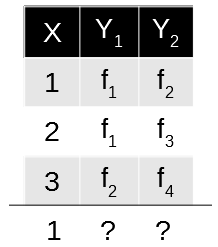
Now we have to calculate prior and posteriori probabilities for each class for test instance X = 1
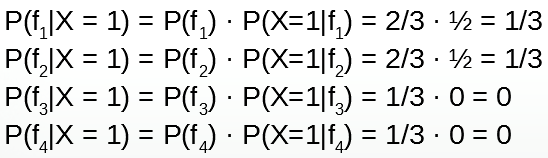


In [ ]:
classifier = MLkNN(k=3)
classifier.fit(reduced_train, y_train)

**Classifier chain**

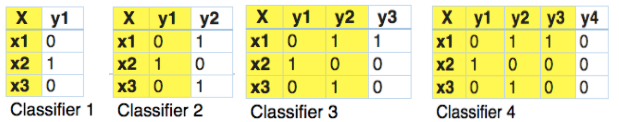

In [ ]:
pipeline = Pipeline([
    ('clf', ClassifierChain(LinearSVC()))
])
pipeline.steps

[('clf',
  ClassifierChain(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                           fit_intercept=True,
                                           intercept_scaling=1,
                                           loss='squared_hinge', max_iter=1000,
                                           multi_class='ovr', penalty='l2',
                                           random_state=None, tol=0.0001,
                                           verbose=0),
                  cv=None, order=None, random_state=None))]

In [ ]:
y_train.shape

(98864, 31)

In [ ]:
clfs = []
clfs.append(ClassifierChain(LinearSVC()))
#clfs.append(ClassifierChain(SGDClassifier()))
#clfs.append(ClassifierChain(RandomForestClassifier()))
#clfs.append(ClassifierChain(GradientBoostingClassifier()))
results = []
for classifier in clfs:
    pipeline.set_params(clf = classifier,clf__base_estimator__verbose=1)
    pipeline.fit(x_train, y_train)
    predictions = pipeline.predict(x_test)
    results.append((hamming_loss(y_test,predictions),accuracy_score(y_test,predictions)))
    print(hamming_loss(y_test,predictions),accuracy_score(y_test,predictions))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.05016633920313629 0.6054309864858025


In [ ]:
results

[(0.05742038494986817, 0.5671407602368781),
 (0.053690981792414195, 0.5935364680872602),
 (0.07092998108840595, 0.46629042870881204)]

**Ensemble of classifier chains**

In [ ]:
classifier = [ClassifierChain(LinearSVC(), order='random', random_state=i)
          for i in range(5)]
for chain in classifier:
    chain.fit(reduced_tfbns_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [ ]:
predictions_chain = np.array([chain.predict(reduced_tfbns_test) for chain in
                          classifier])

In [ ]:
predictions = predictions_chain .mean(axis=0)

In [ ]:
predictions = np.where(predictions > 0.5, 1, 0)

In [ ]:

hamming_loss(y_test,predictions)

0.023934400124916808

**Subset Accuracy**

In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

In [ ]:

accuracy_score(y_test,predictions)

0.5135271141357743

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance


# initialize Binary Relevance multi-label classifier
# with an SVM classifier
# SVM in scikit only supports the X matrix in sparse representation

classifier = BinaryRelevance(
    classifier = LinearSVC(),
   
)

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)